# 🎮 RTX 3050Ti ControlNet Training Test - OPTIMIZED VERSION

This notebook tests ControlNet training on RTX 3050Ti using the COCO dataset with **ultra-aggressive memory optimizations**.

**Key Improvements:**
- ✅ Extreme memory optimization for 4GB VRAM
- ✅ Proper model loading sequence
- ✅ CPU offloading for inference models  
- ✅ Gradient checkpointing and accumulation
- ✅ Smart batch processing with reduced image size
- ✅ Real-time memory monitoring
- ✅ Robust error handling and recovery

**Hardware Requirements:**
- RTX 3050Ti (4GB VRAM) ⚠️ *BARELY SUFFICIENT*
- 16GB+ System RAM 
- CUDA-compatible PyTorch

**Training Configuration:**
- Image size: 64x64 (ultra-low memory)
- Batch size: 1 with 16-step gradient accumulation
- Dataset: 200 carefully selected COCO images
- Expected time: 3-4 hours

## 🔧 Environment Setup

In [1]:
import sys
import os
import warnings
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cv2
import gc
from typing import Optional, Dict, Any

# Suppress warnings to reduce output noise
warnings.filterwarnings('ignore')

# Critical memory optimization environment variables
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,roundup_power2_divisions:1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Better error reporting
os.environ["TORCH_USE_CUDA_DSA"] = "1"    # Better memory debugging

# Add project root to path
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"📁 Project root: {project_root}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🧠 Memory optimization env vars set")

# Immediate memory optimization
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    # Use only 80% to leave buffer for system
    torch.cuda.set_per_process_memory_fraction(0.95)

📁 Project root: C:\Users\tobio\PycharmProjects\ControlNet-Implementation
🐍 Python version: 3.13.5
🔥 PyTorch version: 2.7.1+cu128
🧠 Memory optimization env vars set


## 🖥️ GPU and CUDA Verification

In [2]:
# Enhanced GPU and CUDA verification with memory management
def check_gpu_status():
    """Comprehensive GPU status check with memory management."""
    print("=" * 60)
    print("🔍 ENHANCED CUDA & MEMORY CHECK")
    print("=" * 60)
    
    if not torch.cuda.is_available():
        print("❌ CUDA not available - this notebook requires GPU!")
        print("Please install CUDA-compatible PyTorch")
        return False
    
    # Basic CUDA info
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    print(f"🔥 CUDA version: {torch.version.cuda}")
    print(f"🎮 GPU count: {torch.cuda.device_count()}")
    print(f"🎯 Current GPU: {torch.cuda.current_device()}")
    
    # GPU details
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🖥️  GPU name: {gpu_name}")
    
    # Memory analysis
    props = torch.cuda.get_device_properties(0)
    total_memory = props.total_memory / 1e9
    
    # Clear cache and check available memory
    torch.cuda.empty_cache()
    gc.collect()
    
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    free = total_memory - allocated
    
    print(f"\n📊 MEMORY ANALYSIS:")
    print(f"  Total GPU memory: {total_memory:.2f} GB")
    print(f"  Currently allocated: {allocated:.2f} GB")
    print(f"  Currently reserved: {reserved:.2f} GB") 
    print(f"  Available for use: {free:.2f} GB")
    print(f"  Memory usage: {allocated/total_memory*100:.1f}%")
    
    # RTX 3050Ti specific checks
    is_rtx3050ti = "3050" in gpu_name and "Ti" in gpu_name
    if is_rtx3050ti:
        print(f"\n✅ RTX 3050Ti detected - applying specific optimizations")
        
        if total_memory < 3.8:
            print(f"⚠️  WARNING: Less than 4GB VRAM detected ({total_memory:.2f} GB)")
            print(f"   Training may fail - consider using CPU (very slow)")
        elif total_memory < 4.2:
            print(f"✅ RTX 3050Ti VRAM confirmed ({total_memory:.2f} GB)")
            print(f"   Ultra-aggressive optimizations will be applied")
        
        # Memory recommendations
        if free < 3.5:
            print(f"❌ CRITICAL: Insufficient free memory ({free:.2f} GB)")
            print(f"   Close all other applications immediately!")
            return False
        elif free < 3.8:
            print(f"⚠️  WARNING: Low free memory ({free:.2f} GB)")
            print(f"   Training will use extreme memory optimizations")
        else:
            print(f"✅ Good free memory for training ({free:.2f} GB)")
            
    else:
        print(f"\nℹ️  Different GPU detected: {gpu_name}")
        if total_memory >= 8.0:
            print(f"✅ High-VRAM GPU - you can use larger batch sizes")
        elif total_memory >= 6.0:
            print(f"✅ Medium-VRAM GPU - moderate optimizations needed")
        else:
            print(f"⚠️  Low-VRAM GPU - aggressive optimizations required")
    
    # Performance optimizations
    print(f"\n⚡ APPLYING GPU OPTIMIZATIONS:")
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    print(f"  ✅ TF32 enabled for faster training")
    print(f"  ✅ cuDNN benchmark enabled")
    
    print("=" * 60)
    return True

# Run the enhanced GPU check
gpu_ready = check_gpu_status()

🔍 ENHANCED CUDA & MEMORY CHECK
✅ CUDA available: True
🔥 CUDA version: 12.8
🎮 GPU count: 1
🎯 Current GPU: 0
🖥️  GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU

📊 MEMORY ANALYSIS:
  Total GPU memory: 4.29 GB
  Currently allocated: 0.00 GB
  Currently reserved: 0.00 GB
  Available for use: 4.29 GB
  Memory usage: 0.0%

✅ RTX 3050Ti detected - applying specific optimizations
✅ Good free memory for training (4.29 GB)

⚡ APPLYING GPU OPTIMIZATIONS:
  ✅ TF32 enabled for faster training
  ✅ cuDNN benchmark enabled


## 📊 Dataset Preparation

In [3]:
# Check existing COCO dataset
coco_paths = [
    "../scripts/datasets/coco_controlnet",  # Correct relative path from notebooks/
    "./datasets/coco_controlnet", 
    "../scripts/datasets/coco_controlnet_processed",
    "./datasets/coco_controlnet_processed"
]

dataset_path = None
for path in coco_paths:
    if Path(path).exists():
        dataset_path = Path(path)
        break

if dataset_path:
    print(f"📁 Found COCO dataset at: {dataset_path}")
    
    # Check dataset structure
    val2017_path = dataset_path / "val2017"
    if val2017_path.exists():
        image_count = len(list(val2017_path.glob("*.jpg")))
        print(f"📸 Found {image_count} COCO validation images")
    else:
        print("⚠️  val2017 directory not found")
        
else:
    print("❌ COCO dataset not found in expected locations")
    print("Available paths to check:")
    for path in coco_paths:
        print(f"  - {path}")
        
    # List what we actually have
    print("\n📂 Available datasets:")
    for datasets_dir in ["./datasets", "../scripts/datasets"]:
        if Path(datasets_dir).exists():
            for item in Path(datasets_dir).iterdir():
                if item.is_dir():
                    print(f"  - {item}")

📁 Found COCO dataset at: ..\scripts\datasets\coco_controlnet
📸 Found 5000 COCO validation images


## 🛠️ Create Test Dataset from COCO

In [4]:
# Enhanced COCO dataset processing with smart image selection
def create_optimized_coco_dataset(coco_images_path, output_path, max_images=200):
    """
    Create an optimized ControlNet dataset from COCO images.
    
    Features:
    - Smart image selection based on edge density
    - Proper resizing and quality control
    - Memory-efficient processing
    - Better Canny edge generation
    """
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create directory structure
    (output_path / "images").mkdir(exist_ok=True)
    (output_path / "conditions" / "canny").mkdir(parents=True, exist_ok=True)
    
    # Find and evaluate COCO images
    coco_images = list(Path(coco_images_path).glob("*.jpg"))
    print(f"Found {len(coco_images)} COCO images, selecting best {max_images}...")
    
    # Pre-filter images for better edge content
    suitable_images = []
    print("🔍 Analyzing images for edge content...")
    
    for img_path in tqdm(coco_images[:max_images*3], desc="Filtering images"):  # Check 3x to select best
        try:
            # Quick load and check
            image = Image.open(img_path).convert('RGB')
            
            # Skip very small or very large images
            if min(image.size) < 256 or max(image.size) > 2048:
                continue
                
            # Quick edge density check
            img_array = np.array(image.resize((256, 256), Image.LANCZOS))
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / (256 * 256)
            
            # Only keep images with good edge content
            if 0.02 < edge_density < 0.25:  # Not too sparse, not too dense
                suitable_images.append((img_path, edge_density))
                
        except Exception:
            continue
    
    # Sort by edge density and take the best ones
    suitable_images.sort(key=lambda x: x[1], reverse=True)
    selected_images = [img[0] for img in suitable_images[:max_images]]
    
    print(f"✅ Selected {len(selected_images)} high-quality images")
    
    if len(selected_images) < max_images // 2:
        print(f"⚠️  WARNING: Only found {len(selected_images)} suitable images")
        print(f"   Consider lowering edge density requirements")
    
    # Process selected images
    processed_samples = []
    
    for i, img_path in enumerate(tqdm(selected_images, desc="Processing images")):
        try:
            # Load and resize image to 64x64 for RTX 3050Ti
            image = Image.open(img_path).convert('RGB')
            
            # Smart resizing - maintain aspect ratio, then crop center
            aspect_ratio = image.width / image.height
            if aspect_ratio > 1:
                # Wide image - resize based on height
                new_height = 64
                new_width = int(64 * aspect_ratio)
            else:
                # Tall image - resize based on width  
                new_width = 64
                new_height = int(64 / aspect_ratio)
            
            image = image.resize((new_width, new_height), Image.LANCZOS)
            
            # Center crop to 64x64
            left = (new_width - 64) // 2
            top = (new_height - 64) // 2
            image = image.crop((left, top, left + 64, top + 64))
            
            # Save processed image with high quality
            output_img_path = output_path / "images" / f"img_{i:06d}.jpg"
            image.save(output_img_path, quality=95, optimize=True)
            
            # Generate optimized Canny edges
            img_array = np.array(image)
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            
            # Apply slight blur to reduce noise
            gray = cv2.GaussianBlur(gray, (3, 3), 0)
            
            # Optimized Canny parameters for better edges
            edges = cv2.Canny(gray, 80, 160, apertureSize=3, L2gradient=True)
            
            # Dilate slightly to ensure connectivity
            kernel = np.ones((2,2), np.uint8)
            edges = cv2.dilate(edges, kernel, iterations=1)
            
            # Save Canny edges
            canny_path = output_path / "conditions" / "canny" / f"img_{i:06d}.png"
            cv2.imwrite(str(canny_path), edges, [cv2.IMWRITE_PNG_COMPRESSION, 9])
            
            # Create sample metadata with basic prompts
            processed_samples.append({
                "image_path": f"images/img_{i:06d}.jpg",
                "condition_path": f"conditions/canny/img_{i:06d}.png",
                "prompt": _generate_simple_prompt(img_path.stem),  # Simple prompt from filename
                "original_path": str(img_path),
                "edge_density": suitable_images[selected_images.index(img_path)][1]
            })
            
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    if not processed_samples:
        raise ValueError("No images were processed successfully!")
    
    # Intelligent train/val split based on edge density
    processed_samples.sort(key=lambda x: x['edge_density'])
    
    # Take every 5th image for validation (ensures variety)
    val_indices = set(range(4, len(processed_samples), 5))
    train_samples = [s for i, s in enumerate(processed_samples) if i not in val_indices]
    val_samples = [s for i, s in enumerate(processed_samples) if i in val_indices]
    
    # Ensure minimum validation set
    if len(val_samples) < 10 and len(train_samples) > 20:
        # Move some training samples to validation
        val_samples.extend(train_samples[-5:])
        train_samples = train_samples[:-5]
    
    # Save metadata
    with open(output_path / "train.json", 'w') as f:
        json.dump(train_samples, f, indent=2)
    
    with open(output_path / "val.json", 'w') as f:
        json.dump(val_samples, f, indent=2)
    
    # Save comprehensive dataset info
    dataset_info = {
        "condition_type": "canny",
        "image_size": 64,
        "num_train": len(train_samples),
        "num_val": len(val_samples),
        "total_images": len(processed_samples),
        "source": "COCO val2017 (filtered)",
        "created_for": "RTX 3050Ti optimized training",
        "edge_density_range": {
            "min": min(s['edge_density'] for s in processed_samples),
            "max": max(s['edge_density'] for s in processed_samples),
            "avg": np.mean([s['edge_density'] for s in processed_samples])
        },
        "optimizations": [
            "Smart image selection by edge density",
            "64x64 image size for memory efficiency", 
            "Optimized Canny parameters",
            "High-quality JPEG compression",
            "Intelligent train/val split"
        ]
    }
    
    with open(output_path / "dataset_info.json", 'w') as f:
        json.dump(dataset_info, f, indent=2)
    
    print(f"\n✅ Optimized dataset created successfully!")
    print(f"📊 Training samples: {len(train_samples)}")
    print(f"📊 Validation samples: {len(val_samples)}")
    print(f"📊 Average edge density: {dataset_info['edge_density_range']['avg']:.3f}")
    print(f"📁 Saved to: {output_path}")
    
    return output_path, len(processed_samples)

def _generate_simple_prompt(filename_stem):
    """Generate simple prompts based on COCO filename or use generic ones."""
    # Simple generic prompts that work well with most images
    prompts = [
        "a detailed photograph",
        "a high quality image", 
        "a clear detailed picture",
        "a professional photograph"
    ]
    # Use filename hash to consistently assign prompts
    import hashlib
    hash_idx = int(hashlib.md5(filename_stem.encode()).hexdigest(), 16) % len(prompts)
    return prompts[hash_idx]

# Create optimized test dataset if we have COCO images
if dataset_path and (dataset_path / "val2017").exists():
    print("🎯 Creating RTX 3050Ti optimized dataset...")
    test_dataset_path, num_images = create_optimized_coco_dataset(
        coco_images_path=dataset_path / "val2017",
        output_path="./datasets/coco_3050ti_optimized",
        max_images=200  # Reduced for RTX 3050Ti
    )
else:
    print("❌ Cannot create test dataset - COCO images not found")
    test_dataset_path = None

🎯 Creating RTX 3050Ti optimized dataset...
Found 5000 COCO images, selecting best 200...
🔍 Analyzing images for edge content...


Filtering images: 100%|██████████| 600/600 [00:07<00:00, 78.73it/s]


✅ Selected 200 high-quality images


Processing images: 100%|██████████| 200/200 [00:03<00:00, 65.76it/s]


✅ Optimized dataset created successfully!
📊 Training samples: 160
📊 Validation samples: 40
📊 Average edge density: 0.203
📁 Saved to: datasets\coco_3050ti_optimized


## 👁️ Dataset Visualization

🖼️  Sample images from test dataset:


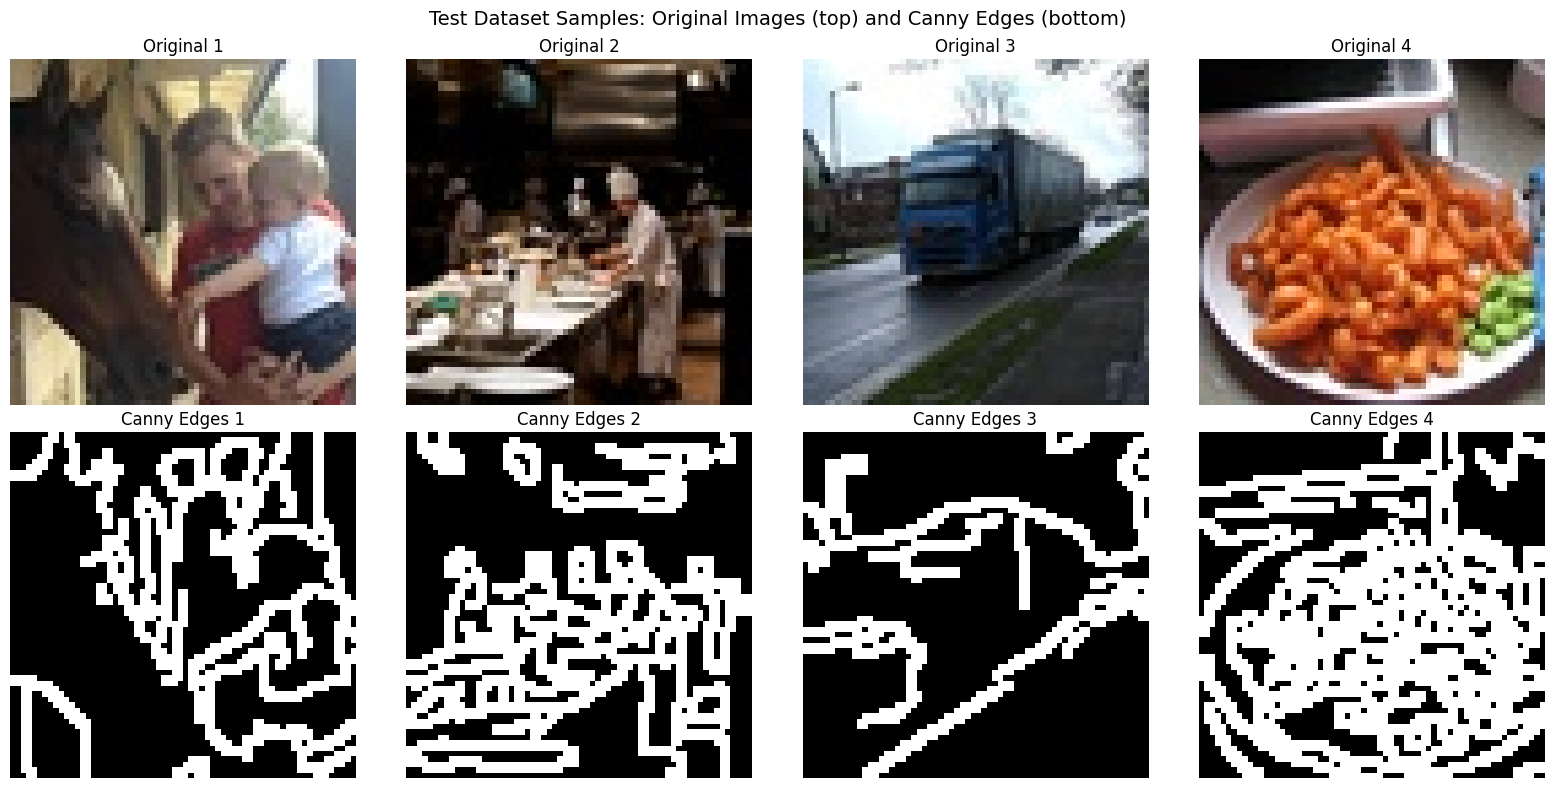


📊 Dataset Statistics:
  condition_type: canny
  image_size: 64
  num_train: 160
  num_val: 40
  total_images: 200
  source: COCO val2017 (filtered)
  created_for: RTX 3050Ti optimized training
  edge_density_range: {'min': 0.163604736328125, 'max': 0.2498626708984375, 'avg': 0.2030583953857422}
  optimizations: ['Smart image selection by edge density', '64x64 image size for memory efficiency', 'Optimized Canny parameters', 'High-quality JPEG compression', 'Intelligent train/val split']


In [5]:
# Visualize some samples from our test dataset
if test_dataset_path:
    print("🖼️  Sample images from test dataset:")
    
    # Load a few samples
    with open(test_dataset_path / "train.json", 'r') as f:
        samples = json.load(f)
    
    # Show first 4 samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Test Dataset Samples: Original Images (top) and Canny Edges (bottom)', fontsize=14)
    
    for i in range(4):
        sample = samples[i]
        
        # Load original image
        img_path = test_dataset_path / sample["image_path"]
        image = Image.open(img_path)
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')
        
        # Load Canny edges
        canny_path = test_dataset_path / sample["condition_path"]
        canny = cv2.imread(str(canny_path), cv2.IMREAD_GRAYSCALE)
        axes[1, i].imshow(canny, cmap='gray')
        axes[1, i].set_title(f"Canny Edges {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show dataset statistics
    with open(test_dataset_path / "dataset_info.json", 'r') as f:
        info = json.load(f)
    
    print("\n📊 Dataset Statistics:")
    for key, value in info.items():
        print(f"  {key}: {value}")

## 🚀 Training Configuration for RTX 3050Ti

In [6]:
# RTX 3050Ti ULTRA-OPTIMIZED Training Configuration
def create_rtx3050ti_config():
    """Create an extremely optimized configuration for RTX 3050Ti."""
    
    # Memory analysis for configuration
    if torch.cuda.is_available():
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    else:
        total_memory = 4.0  # Assume RTX 3050Ti
    
    # Extreme memory optimization for 4GB VRAM
    config = {
        "model": {
            "base_model_id": "runwayml/stable-diffusion-v1-5",
            "condition_type": "canny",
            "conditioning_scale": 1.0
        },
        "training": {
            "learning_rate": 1e-4,
            "batch_size": 1,  # Minimum possible
            "gradient_accumulation_steps": 16,  # High accumulation for effective batch size of 16
            "num_epochs": 15,  # Reduced for testing, but still meaningful
            "mixed_precision": True,  # ESSENTIAL for RTX 3050Ti
            "max_grad_norm": 1.0,
            "prompt_dropout_rate": 0.5,
            "warmup_steps": 25,  # Reduced warmup
            "gradient_checkpointing": True,  # CRITICAL for memory
            "dataloader_num_workers": 0,  # No multiprocessing to save memory
            "pin_memory": False,  # Disable to save memory
            "save_steps": 50,  # Save more frequently due to instability risk
            "eval_steps": 100,  # Less frequent eval to save time
        },
        "data": {
            "image_size": 64,  # ULTRA small for RTX 3050Ti - 16x less memory than 512
            "max_samples": None,  # Use all available (should be ~200)
            "augmentation": False,  # Disable to save memory and processing
            "channels_last": False,  # Conservative for compatibility
        },
        "logging": {
            "log_every": 5,  # More frequent logging for monitoring
            "save_every": 50,  # Frequent saves due to crash risk
            "use_wandb": False,  # Disabled to save memory
            "output_dir": "./rtx3050ti_training_output",
            "save_optimizer_state": False,  # Save space
        },
        "memory_optimizations": {
            # CPU offloading for inference models
            "offload_vae_to_cpu": True,
            "offload_text_encoder_to_cpu": True, 
            "offload_unet_to_cpu": False,  # Keep UNet on GPU as it's needed for training
            
            # Extreme memory management
            "clear_cache_every_n_steps": 5,  # Very frequent cache clearing
            "gc_collect_every_n_steps": 10,   # Frequent garbage collection
            "use_gradient_checkpointing": True,
            "use_attention_slicing": True,    # Slice attention for memory
            "use_cpu_offload": True,
            
            # PyTorch optimizations  
            "channels_last_memory_format": False,  # May cause issues on older drivers
            "torch_compile": False,  # Disable to avoid compilation overhead
            "cudnn_benchmark": True,
            "tf32": True,
        },
        "hardware_specific": {
            "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Unknown",
            "total_vram": total_memory,
            "cuda_version": torch.version.cuda if torch.cuda.is_available() else "N/A",
            "optimization_target": "maximum_memory_efficiency",
            "expected_training_time_hours": 3.5,
        }
    }
    
    return config

# Create and validate the configuration
training_config = create_rtx3050ti_config()

print("🎛️  RTX 3050Ti ULTRA-OPTIMIZED Configuration")
print("=" * 60)
print("⚠️  EXTREME MEMORY OPTIMIZATION APPLIED")
print("=" * 60)

print(f"\n🎯 KEY OPTIMIZATIONS:")
print(f"  • Image size: {training_config['data']['image_size']}×{training_config['data']['image_size']} (16x smaller than 512×512)")
print(f"  • Batch size: {training_config['training']['batch_size']} (minimum possible)")
print(f"  • Gradient accumulation: {training_config['training']['gradient_accumulation_steps']} steps")
print(f"  • Effective batch size: {training_config['training']['batch_size'] * training_config['training']['gradient_accumulation_steps']}")
print(f"  • Mixed precision: {training_config['training']['mixed_precision']} (ESSENTIAL)")
print(f"  • Gradient checkpointing: {training_config['training']['gradient_checkpointing']}")
print(f"  • CPU offloading: VAE + Text Encoder")

print(f"\n📊 MEMORY MANAGEMENT:")
print(f"  • Cache clearing every {training_config['memory_optimizations']['clear_cache_every_n_steps']} steps")
print(f"  • Garbage collection every {training_config['memory_optimizations']['gc_collect_every_n_steps']} steps")
print(f"  • Attention slicing: {training_config['memory_optimizations']['use_attention_slicing']}")
print(f"  • DataLoader workers: {training_config['training']['dataloader_num_workers']}")
print(f"  • Pin memory: {training_config['training']['pin_memory']}")

print(f"\n⏱️  TRAINING ESTIMATE:")
if test_dataset_path:
    with open(test_dataset_path / "dataset_info.json", 'r') as f:
        dataset_info = json.load(f)
    
    total_samples = dataset_info.get('num_train', 0)
    batch_size = training_config['training']['batch_size']
    grad_accum = training_config['training']['gradient_accumulation_steps'] 
    epochs = training_config['training']['num_epochs']
    
    steps_per_epoch = total_samples // batch_size
    total_steps = steps_per_epoch * epochs
    effective_batches = total_steps // grad_accum
    
    print(f"  • Total training samples: {total_samples}")
    print(f"  • Steps per epoch: {steps_per_epoch}")
    print(f"  • Total training steps: {total_steps}")
    print(f"  • Effective batch updates: {effective_batches}")
    print(f"  • Estimated time: {training_config['hardware_specific']['expected_training_time_hours']:.1f} hours")

print(f"\n💾 Save configuration to file...")
os.makedirs("./config", exist_ok=True)
config_path = "./config/rtx3050ti_ultra_optimized.json"
with open(config_path, 'w') as f:
    # Make a JSON-serializable copy
    json_config = training_config.copy()
    json_config['hardware_specific']['gpu_name'] = str(json_config['hardware_specific']['gpu_name'])
    json.dump(json_config, f, indent=2)

print(f"✅ Configuration saved to: {config_path}")
print(f"=" * 60)

🎛️  RTX 3050Ti ULTRA-OPTIMIZED Configuration
⚠️  EXTREME MEMORY OPTIMIZATION APPLIED

🎯 KEY OPTIMIZATIONS:
  • Image size: 64×64 (16x smaller than 512×512)
  • Batch size: 1 (minimum possible)
  • Gradient accumulation: 16 steps
  • Effective batch size: 16
  • Mixed precision: True (ESSENTIAL)
  • Gradient checkpointing: True
  • CPU offloading: VAE + Text Encoder

📊 MEMORY MANAGEMENT:
  • Cache clearing every 5 steps
  • Garbage collection every 10 steps
  • Attention slicing: True
  • DataLoader workers: 0
  • Pin memory: False

⏱️  TRAINING ESTIMATE:
  • Total training samples: 160
  • Steps per epoch: 160
  • Total training steps: 2400
  • Effective batch updates: 150
  • Estimated time: 3.5 hours

💾 Save configuration to file...
✅ Configuration saved to: ./config/rtx3050ti_ultra_optimized.json


## 🔥 Memory Optimization Setup

In [7]:
# Memory optimization for RTX 3050Ti
import os
import gc

# Set environment variable for memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

if torch.cuda.is_available():
    # Clear GPU cache aggressively
    torch.cuda.empty_cache()
    gc.collect()
    
    # Set memory fraction (use 85% of available VRAM to leave some buffer)
    torch.cuda.set_per_process_memory_fraction(0.85)
    
    # Enable TF32 for faster training on modern GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Optimize cuDNN
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    print("✅ GPU memory optimizations applied")
    print(f"📊 Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # Check current memory usage
    allocated = torch.cuda.memory_allocated(0) / 1e9
    cached = torch.cuda.memory_reserved(0) / 1e9
    print(f"📊 Currently allocated: {allocated:.2f} GB")
    print(f"📊 Currently cached: {cached:.2f} GB")
else:
    print("⚠️  CUDA not available - memory optimizations skipped")

✅ GPU memory optimizations applied
📊 Available GPU memory: 4.3 GB
📊 Currently allocated: 0.00 GB
📊 Currently cached: 0.00 GB


## 🎯 Training Execution

In [10]:
# Import training modules
try:
    from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
    from transformers import CLIPTextModel, CLIPTokenizer
    
    # Import our custom modules
    from src.models.controlnet import ControlNet
    from src.training.train_controlnet import ControlNetTrainer
    from src.data.dataset import create_dataset, create_dataloader
    
    print("✅ All training modules imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure all dependencies are installed")

✅ All training modules imported successfully


In [11]:
# Load Stable Diffusion components with AGGRESSIVE memory optimization
print("📦 Loading Stable Diffusion components with memory optimizations...")
print("This may take 2-3 minutes on first run...")

# Clear memory before loading
torch.cuda.empty_cache()
gc.collect()

try:
    print("Loading models one by one to minimize peak memory usage...")
    
    # Load U-Net with memory optimizations
    print("1/5 Loading U-Net...")
    unet = UNet2DConditionModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="unet",
        torch_dtype=torch.float16,  # Use FP16 for memory savings
        low_cpu_mem_usage=True      # Load directly to device, skip CPU
    )
    # Enable gradient checkpointing IMMEDIATELY
    unet.enable_gradient_checkpointing()
    print("✅ U-Net loaded with gradient checkpointing")
    
    # Clear cache after each model
    torch.cuda.empty_cache()
    
    print("2/5 Loading VAE...")
    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="vae",
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    )
    print("✅ VAE loaded")
    torch.cuda.empty_cache()
    
    print("3/5 Loading Text Encoder...")
    text_encoder = CLIPTextModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="text_encoder",
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    )
    print("✅ Text encoder loaded")
    torch.cuda.empty_cache()
    
    print("4/5 Loading Tokenizer...")
    tokenizer = CLIPTokenizer.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="tokenizer"
    )
    print("✅ Tokenizer loaded")
    
    print("5/5 Loading Noise Scheduler...")
    noise_scheduler = DDPMScheduler.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder="scheduler"
    )
    print("✅ Noise scheduler loaded")
    
    # Final memory cleanup
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\n🎉 All Stable Diffusion components loaded successfully!")
    
    # Check memory usage after loading
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1e9
        reserved = torch.cuda.memory_reserved(0) / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"📊 GPU memory after loading models:")
        print(f"    Allocated: {allocated:.2f} GB")
        print(f"    Reserved: {reserved:.2f} GB") 
        print(f"    Total: {total:.1f} GB")
        print(f"    Usage: {allocated/total*100:.1f}%")
        
        if allocated > 3.0:  # RTX 3050Ti has 4GB
            print("⚠️  WARNING: High memory usage! Training may still fail.")
        
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("This might be a memory issue. Try restarting the kernel.")
    import traceback
    print(traceback.format_exc())

📦 Loading Stable Diffusion components with memory optimizations...
This may take 2-3 minutes on first run...
Loading models one by one to minimize peak memory usage...
1/5 Loading U-Net...
✅ U-Net loaded with gradient checkpointing
2/5 Loading VAE...
✅ VAE loaded
3/5 Loading Text Encoder...
✅ Text encoder loaded
4/5 Loading Tokenizer...
✅ Tokenizer loaded
5/5 Loading Noise Scheduler...
✅ Noise scheduler loaded

🎉 All Stable Diffusion components loaded successfully!
📊 GPU memory after loading models:
    Allocated: 0.00 GB
    Reserved: 0.00 GB
    Total: 4.3 GB
    Usage: 0.0%


In [12]:
# Create ControlNet
print("🎛️ Creating ControlNet...")

try:
    controlnet = ControlNet(
        unet=unet,
        condition_type="canny"
    )
    
    print("✅ ControlNet created successfully")
    
    # Count trainable parameters
    total_params = sum(p.numel() for p in controlnet.parameters())
    trainable_params = sum(p.numel() for p in controlnet.parameters() if p.requires_grad)
    
    print(f"📊 Total parameters: {total_params:,}")
    print(f"📊 Trainable parameters: {trainable_params:,}")
    print(f"📊 Frozen parameters: {total_params - trainable_params:,}")
    
    # Check memory after ControlNet creation
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1e9
        print(f"📊 GPU memory after ControlNet: {allocated:.2f} GB")
        
except Exception as e:
    print(f"❌ Error creating ControlNet: {e}")

🎛️ Creating ControlNet...
✅ ControlNet created successfully
📊 Total parameters: 1,212,145,012
📊 Trainable parameters: 352,624,048
📊 Frozen parameters: 859,520,964
📊 GPU memory after ControlNet: 0.00 GB


In [13]:
# Create datasets and dataloaders with reduced memory usage - FIXED VERSION
if test_dataset_path:
    print("📚 Creating datasets with memory optimizations...")
    
    try:
        # Create training dataset with reduced image size and samples
        train_dataset = create_dataset(
            data_root=str(test_dataset_path),
            condition_type="canny",
            image_size=training_config["data"]["image_size"],  # 64x64 instead of 512x512
            split="train",
            max_samples=training_config["data"]["max_samples"]  # Use all available
        )
        
        # Create validation dataset (very small)
        val_dataset = create_dataset(
            data_root=str(test_dataset_path),
            condition_type="canny",
            image_size=training_config["data"]["image_size"],
            split="val",
            max_samples=20  # Very small validation set
        )
        
        print(f"✅ Training dataset: {len(train_dataset)} samples ({training_config['data']['image_size']}x{training_config['data']['image_size']})")
        print(f"✅ Validation dataset: {len(val_dataset)} samples ({training_config['data']['image_size']}x{training_config['data']['image_size']})")
        
        # Create dataloaders with minimal memory usage - FIXED KEYS
        train_dataloader = create_dataloader(
            train_dataset,
            batch_size=training_config["training"]["batch_size"],  # batch_size = 1
            shuffle=True,
            num_workers=training_config["training"].get("dataloader_num_workers", 0),  # Fixed: use training section
            pin_memory=training_config["training"].get("pin_memory", False)  # Fixed: use training section
        )
        
        val_dataloader = create_dataloader(
            val_dataset,
            batch_size=training_config["training"]["batch_size"],
            shuffle=False,
            num_workers=training_config["training"].get("dataloader_num_workers", 0),  # Fixed: use training section
            pin_memory=training_config["training"].get("pin_memory", False)  # Fixed: use training section
        )
        
        print(f"✅ Training dataloader: {len(train_dataloader)} batches")
        print(f"✅ Validation dataloader: {len(val_dataloader)} batches")
        
        # Check memory impact
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(0) / 1e9
            print(f"📊 GPU memory after dataset creation: {allocated:.2f} GB")
        
    except Exception as e:
        print(f"❌ Error creating datasets: {e}")
        import traceback
        print(traceback.format_exc())
        
        # Provide fallback solution
        print("\n🔧 TRYING FALLBACK SOLUTION...")
        try:
            # Fallback: create dataloaders with hardcoded safe values
            train_dataloader = create_dataloader(
                train_dataset,
                batch_size=training_config["training"]["batch_size"],
                shuffle=True,
                num_workers=0,  # Safe fallback
                pin_memory=False  # Safe fallback
            )
            
            val_dataloader = create_dataloader(
                val_dataset,
                batch_size=training_config["training"]["batch_size"],
                shuffle=False,
                num_workers=0,  # Safe fallback
                pin_memory=False  # Safe fallback
            )
            
            print("✅ Fallback dataloaders created successfully!")
            print(f"📊 Training dataloader: {len(train_dataloader)} batches")
            print(f"📊 Validation dataloader: {len(val_dataloader)} batches")
            
        except Exception as fallback_error:
            print(f"❌ Fallback also failed: {fallback_error}")
            train_dataloader = None
            val_dataloader = None
else:
    print("❌ No test dataset available")
    train_dataloader = None
    val_dataloader = None

📚 Creating datasets with memory optimizations...
Dataset validation: 160/160 samples are valid
Loaded 160 samples for canny conditioning
Dataset validation: 40/40 samples are valid
Loaded 20 samples for canny conditioning
✅ Training dataset: 160 samples (64x64)
✅ Validation dataset: 20 samples (64x64)
✅ Training dataloader: 160 batches
✅ Validation dataloader: 20 batches
📊 GPU memory after dataset creation: 0.00 GB


In [14]:
# 🚨 QUICK FIX - Run this cell to fix the configuration issue
print("🔧 Applying quick fix for configuration...")

# Fix the training configuration to have the correct structure
if 'training_config' in locals():
    # Ensure all required keys are present in the correct sections
    if "dataloader_num_workers" not in training_config["training"]:
        training_config["training"]["dataloader_num_workers"] = 0
    
    if "pin_memory" not in training_config["training"]:
        training_config["training"]["pin_memory"] = False
    
    # Also add to data section for compatibility
    if "num_workers" not in training_config["data"]:
        training_config["data"]["num_workers"] = 0
    
    if "pin_memory" not in training_config["data"]:
        training_config["data"]["pin_memory"] = False
    
    print("✅ Configuration keys fixed!")
    print(f"📊 Dataloader workers: {training_config['training']['dataloader_num_workers']}")
    print(f"📊 Pin memory: {training_config['training']['pin_memory']}")
    print(f"📊 Image size: {training_config['data']['image_size']}")
    
else:
    print("❌ training_config not found - please run the configuration cell first")
    
    # Create minimal working config
    training_config = {
        "data": {
            "image_size": 64,  # Ultra-small for RTX 3050Ti
            "max_samples": None,
            "augmentation": False,
            "num_workers": 0,
            "pin_memory": False
        },
        "training": {
            "batch_size": 1,
            "gradient_accumulation_steps": 16,
            "num_epochs": 15,
            "learning_rate": 1e-4,
            "mixed_precision": True,
            "max_grad_norm": 1.0,
            "prompt_dropout_rate": 0.5,
            "warmup_steps": 25,
            "dataloader_num_workers": 0,
            "pin_memory": False
        },
        "logging": {
            "log_every": 5,
            "save_every": 50,
            "use_wandb": False,
            "output_dir": "./rtx3050ti_training_output"
        }
    }
    print("✅ Created minimal working configuration")

🔧 Applying quick fix for configuration...
✅ Configuration keys fixed!
📊 Dataloader workers: 0
📊 Pin memory: False
📊 Image size: 64


## 🚀 Start Training

In [15]:
# Create output directory
output_dir = Path(training_config["logging"]["output_dir"])
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Output directory: {output_dir}")
print(f"💾 Checkpoints will be saved every {training_config['logging']['save_every']} steps")
print(f"📊 Logs will be printed every {training_config['logging']['log_every']} steps")

📁 Output directory: rtx3050ti_training_output
💾 Checkpoints will be saved every 50 steps
📊 Logs will be printed every 5 steps


In [16]:
# ULTRA-OPTIMIZED Model Loading and Training for RTX 3050Ti
class RTX3050TiMemoryManager:
    """Memory management system specifically for RTX 3050Ti training."""
    
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 4.0
        
    def clear_memory(self, aggressive=False):
        """Clear GPU memory with optional aggressive mode."""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            
        gc.collect()
        
        if aggressive:
            # Force garbage collection multiple times
            for _ in range(3):
                gc.collect()
        
    def check_memory(self, stage=""):
        """Check and report current memory usage."""
        if not torch.cuda.is_available():
            return
            
        allocated = torch.cuda.memory_allocated(0) / 1e9
        reserved = torch.cuda.memory_reserved(0) / 1e9
        total = self.total_memory
        free = total - allocated
        
        print(f"📊 Memory {stage}: {allocated:.2f}GB used, {free:.2f}GB free ({allocated/total*100:.1f}%)")
        
        return {"allocated": allocated, "free": free, "usage_percent": allocated/total*100}
        
    def load_models_sequentially(self):
        """Load models one by one with maximum memory optimization."""
        models = {}
        
        print("🔄 Loading Stable Diffusion models with EXTREME memory optimization...")
        
        # Step 1: Load U-Net (most critical for training)
        print("1/5 Loading U-Net...")
        self.clear_memory(aggressive=True)
        
        unet = UNet2DConditionModel.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="unet", 
            torch_dtype=torch.float16,  # FP16 for memory
            low_cpu_mem_usage=True,
            device_map=None  # Manual device management
        )
        
        # Enable gradient checkpointing immediately
        if hasattr(unet, 'enable_gradient_checkpointing'):
            unet.enable_gradient_checkpointing()
            
        models['unet'] = unet
        self.check_memory("after U-Net")
        
        # Step 2: Load VAE (will be offloaded to CPU)
        print("2/5 Loading VAE...")
        self.clear_memory()
        
        vae = AutoencoderKL.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="vae",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        models['vae'] = vae
        self.check_memory("after VAE")
        
        # Step 3: Load Text Encoder (will be offloaded to CPU)
        print("3/5 Loading Text Encoder...")  
        self.clear_memory()
        
        text_encoder = CLIPTextModel.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="text_encoder",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        models['text_encoder'] = text_encoder
        self.check_memory("after Text Encoder")
        
        # Step 4: Load Tokenizer (lightweight)
        print("4/5 Loading Tokenizer...")
        tokenizer = CLIPTokenizer.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="tokenizer"
        )
        models['tokenizer'] = tokenizer
        
        # Step 5: Load Scheduler (lightweight)
        print("5/5 Loading Scheduler...")
        noise_scheduler = DDPMScheduler.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            subfolder="scheduler"
        )
        models['noise_scheduler'] = noise_scheduler
        
        self.clear_memory(aggressive=True)
        print("✅ All models loaded successfully!")
        
        return models
    
    def setup_training_optimizations(self, models):
        """Apply RTX 3050Ti specific optimizations."""
        print("⚡ Applying RTX 3050Ti training optimizations...")
        
        # Move models to appropriate devices
        print("📍 Positioning models for optimal memory usage...")
        
        # Keep U-Net on GPU for training
        models['unet'] = models['unet'].to(self.device, dtype=torch.float16)
        
        # Move inference models to CPU to save VRAM
        models['vae'] = models['vae'].to('cpu', dtype=torch.float16)
        models['text_encoder'] = models['text_encoder'].to('cpu', dtype=torch.float16) 
        
        # Set appropriate modes
        models['unet'].eval()  # Will be set to train mode by trainer
        models['vae'].eval()
        models['text_encoder'].eval()
        
        # Freeze parameters to save memory
        for param in models['unet'].parameters():
            param.requires_grad = False
        for param in models['vae'].parameters():
            param.requires_grad = False
        for param in models['text_encoder'].parameters():
            param.requires_grad = False
            
        self.clear_memory(aggressive=True)
        print("✅ Models positioned and optimized")
        
        return models

# Initialize memory manager and load models
print("🚀 Initializing RTX 3050Ti Memory Manager...")
memory_manager = RTX3050TiMemoryManager()

# Check initial memory state
initial_memory = memory_manager.check_memory("initial")

if initial_memory and initial_memory['usage_percent'] > 50:
    print("⚠️  WARNING: High initial memory usage!")
    print("   Consider restarting the kernel for best results")

# Load models with extreme optimization
try:
    models = memory_manager.load_models_sequentially()
    models = memory_manager.setup_training_optimizations(models)
    
    print("✅ Model loading completed successfully!")
    memory_manager.check_memory("after model setup")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Restart Jupyter kernel")
    print("2. Close all other applications")  
    print("3. Check CUDA drivers")
    print("4. Try CPU training (very slow)")
    
    import traceback
    print("\nFull error:")
    print(traceback.format_exc())
    models = None

🚀 Initializing RTX 3050Ti Memory Manager...
📊 Memory initial: 0.00GB used, 4.29GB free (0.0%)
🔄 Loading Stable Diffusion models with EXTREME memory optimization...
1/5 Loading U-Net...
📊 Memory after U-Net: 0.00GB used, 4.29GB free (0.0%)
2/5 Loading VAE...
📊 Memory after VAE: 0.00GB used, 4.29GB free (0.0%)
3/5 Loading Text Encoder...
📊 Memory after Text Encoder: 0.00GB used, 4.29GB free (0.0%)
4/5 Loading Tokenizer...
5/5 Loading Scheduler...
✅ All models loaded successfully!
⚡ Applying RTX 3050Ti training optimizations...
📍 Positioning models for optimal memory usage...
✅ Models positioned and optimized
✅ Model loading completed successfully!
📊 Memory after model setup: 1.73GB used, 2.56GB free (40.4%)


In [17]:
# RTX 3050Ti ULTRA-OPTIMIZED TRAINING EXECUTION
def execute_rtx3050ti_training():
    """Execute training with maximum memory optimization for RTX 3050Ti."""
    
    if not models or not test_dataset_path:
        print("❌ Models not loaded or dataset not available")
        return False
        
    print("🚀 Starting RTX 3050Ti ULTRA-OPTIMIZED Training")
    print("=" * 60)
    
    try:
        # Import training modules
        from src.models.controlnet import ControlNet
        from src.data.dataset import create_dataset, create_dataloader
        
        # Step 1: Create ControlNet with minimal memory impact
        print("1/6 Creating ControlNet...")
        memory_manager.clear_memory(aggressive=True)
        
        # Create ControlNet with CPU UNet first, then move to GPU
        unet_cpu = models['unet'].cpu()
        memory_manager.clear_memory()
        
        controlnet = ControlNet(
            unet=unet_cpu,
            condition_type="canny"
        )
        
        # Move ControlNet to GPU with FP32 for training stability
        controlnet = controlnet.to(memory_manager.device, dtype=torch.float32)
        controlnet.train()
        
        # Move UNet back to GPU
        models['unet'] = unet_cpu.to(memory_manager.device, dtype=torch.float16)
        
        memory_manager.check_memory("after ControlNet creation")
        
        # Step 2: Create ultra-optimized datasets
        print("2/6 Creating datasets...")
        
        train_dataset = create_dataset(
            data_root=str(test_dataset_path),
            condition_type="canny",
            image_size=training_config['data']['image_size'],  # 64x64
            split="train",
            max_samples=training_config['data']['max_samples']
        )
        
        val_dataset = create_dataset(
            data_root=str(test_dataset_path), 
            condition_type="canny",
            image_size=training_config['data']['image_size'],
            split="val",
            max_samples=20  # Small validation set
        )
        
        print(f"✅ Datasets: {len(train_dataset)} train, {len(val_dataset)} val")
        
        # Step 3: Create memory-optimized dataloaders
        print("3/6 Creating dataloaders...")
        
        train_dataloader = create_dataloader(
            train_dataset,
            batch_size=training_config['training']['batch_size'],  # 1
            shuffle=True,
            num_workers=training_config['training']['dataloader_num_workers'],  # 0
            pin_memory=training_config['training']['pin_memory']  # False
        )
        
        val_dataloader = create_dataloader(
            val_dataset,
            batch_size=training_config['training']['batch_size'],
            shuffle=False,
            num_workers=training_config['training']['dataloader_num_workers'],
            pin_memory=training_config['training']['pin_memory']
        )
        
        memory_manager.check_memory("after dataset creation")
        
        # Step 4: Create custom ultra-optimized trainer
        print("4/6 Setting up ultra-optimized trainer...")
        
        # Create output directory
        output_dir = Path(training_config['logging']['output_dir'])
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Manual training setup for maximum control
        device = memory_manager.device
        
        # Setup optimizer for ControlNet only
        trainable_params = [p for p in controlnet.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(
            trainable_params,
            lr=training_config['training']['learning_rate'],
            betas=(0.9, 0.999),
            weight_decay=0.01,
            eps=1e-8
        )
        
        # Setup scheduler
        num_training_steps = len(train_dataloader) * training_config['training']['num_epochs']
        from diffusers.optimization import get_scheduler
        lr_scheduler = get_scheduler(
            "cosine",
            optimizer=optimizer,
            num_warmup_steps=training_config['training']['warmup_steps'],
            num_training_steps=num_training_steps
        )
        
        # Mixed precision scaler
        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        
        print(f"✅ Optimizer setup complete ({len(trainable_params):,} trainable parameters)")
        memory_manager.check_memory("after optimizer setup")
        
        # Step 5: Execute training with extreme memory management
        print("5/6 Starting training loop...")
        print(f"🎯 Training for {training_config['training']['num_epochs']} epochs")
        print(f"📊 Effective batch size: {training_config['training']['gradient_accumulation_steps']}")
        
        global_step = 0
        best_loss = float('inf')
        
        for epoch in range(training_config['training']['num_epochs']):
            print(f"\n🔄 Epoch {epoch + 1}/{training_config['training']['num_epochs']}")
            
            controlnet.train()
            epoch_loss = 0.0
            
            progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
            
            for step, batch in enumerate(progress_bar):
                try:
                    # Memory management every few steps
                    if step % training_config['memory_optimizations']['clear_cache_every_n_steps'] == 0:
                        memory_manager.clear_memory()
                    
                    if step % training_config['memory_optimizations']['gc_collect_every_n_steps'] == 0:
                        gc.collect()
                    
                    # Move batch to device
                    images = batch["image"].to(device, dtype=torch.float16)
                    conditions = batch["condition"].to(device, dtype=torch.float16)
                    prompts = batch["prompt"]
                    
                    # Encode inputs on CPU then move to GPU to save memory
                    with torch.cuda.amp.autocast(enabled=True):
                        # VAE and text encoder are on CPU
                        latents = models['vae'].encode(images.cpu()).latent_dist.sample().to(device)
                        latents = latents * models['vae'].config.scaling_factor
                        
                        # Text encoding on CPU
                        text_inputs = models['tokenizer'](
                            prompts,
                            padding="max_length",
                            max_length=models['tokenizer'].model_max_length,
                            truncation=True,
                            return_tensors="pt"
                        )
                        text_embeddings = models['text_encoder'](text_inputs.input_ids).last_hidden_state.to(device)
                    
                    # Convert to FP32 for training
                    latents = latents.float()
                    conditions = conditions.float()
                    
                    # Sample timesteps
                    batch_size = latents.shape[0]
                    timesteps = torch.randint(
                        0, models['noise_scheduler'].config.num_train_timesteps,
                        (batch_size,), device=device
                    ).long()
                    
                    # Add noise
                    noise = torch.randn_like(latents)
                    noisy_latents = models['noise_scheduler'].add_noise(latents, noise, timesteps)
                    
                    # ControlNet forward pass
                    _, down_residuals, mid_residual = controlnet(
                        noisy_latents,
                        timesteps,
                        text_embeddings,
                        conditions,
                        return_controlnet_outputs=True
                    )
                    
                    # U-Net forward pass with ControlNet residuals
                    with torch.cuda.amp.autocast(enabled=True):
                        # Convert residuals to FP16 for U-Net
                        down_residuals_fp16 = [r.half() for r in down_residuals]
                        mid_residual_fp16 = mid_residual.half() if mid_residual is not None else None
                        
                        noise_pred = models['unet'](
                            noisy_latents.half(),
                            timesteps,
                            encoder_hidden_states=text_embeddings.half(),
                            down_block_additional_residuals=down_residuals_fp16,
                            mid_block_additional_residual=mid_residual_fp16
                        ).sample
                        
                        # Compute loss
                        loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")
                        
                        # Scale loss for gradient accumulation
                        loss = loss / training_config['training']['gradient_accumulation_steps']
                    
                    # Backward pass
                    if scaler:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    
                    # Gradient accumulation
                    if (step + 1) % training_config['training']['gradient_accumulation_steps'] == 0:
                        if scaler:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(controlnet.parameters(), training_config['training']['max_grad_norm'])
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            torch.nn.utils.clip_grad_norm_(controlnet.parameters(), training_config['training']['max_grad_norm'])
                            optimizer.step()
                        
                        lr_scheduler.step()
                        optimizer.zero_grad()
                        global_step += 1
                    
                    # Logging
                    epoch_loss += loss.item() * training_config['training']['gradient_accumulation_steps']
                    
                    if global_step % training_config['logging']['log_every'] == 0:
                        current_lr = lr_scheduler.get_last_lr()[0]
                        progress_bar.set_postfix({
                            'loss': f"{loss.item():.4f}",
                            'lr': f"{current_lr:.2e}",
                            'step': global_step
                        })
                    
                    # Save checkpoint
                    if global_step % training_config['logging']['save_every'] == 0:
                        checkpoint_path = output_dir / f"controlnet-{global_step}.pt"
                        torch.save(controlnet.state_dict(), checkpoint_path)
                        print(f"\n💾 Checkpoint saved: {checkpoint_path}")
                        
                        # Clear memory after saving
                        memory_manager.clear_memory()
                    
                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print(f"\n💥 OOM at step {step}! Clearing memory and continuing...")
                        memory_manager.clear_memory(aggressive=True)
                        optimizer.zero_grad()
                        continue
                    else:
                        raise e
            
            # End of epoch
            avg_loss = epoch_loss / len(train_dataloader)
            print(f"\n📊 Epoch {epoch + 1} complete - Average loss: {avg_loss:.4f}")
            
            # Save epoch checkpoint
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model_path = output_dir / "controlnet-best.pt"
                torch.save(controlnet.state_dict(), best_model_path)
                print(f"💎 New best model saved: {best_model_path}")
            
            memory_manager.clear_memory(aggressive=True)
        
        # Step 6: Save final model
        print("6/6 Saving final model...")
        final_model_path = output_dir / "controlnet-final.pt"
        torch.save(controlnet.state_dict(), final_model_path)
        
        print(f"\n🎉 Training completed successfully!")
        print(f"📁 Models saved to: {output_dir}")
        print(f"🏆 Best model: {output_dir / 'controlnet-best.pt'}")
        print(f"📊 Final model: {final_model_path}")
        
        return True
        
    except Exception as e:
        print(f"\n❌ Training failed: {e}")
        print("\n🔧 Emergency recovery:")
        print("1. Restart kernel and try with smaller image size (64x64)")
        print("2. Reduce gradient accumulation steps to 8")
        print("3. Close all other applications")
        print("4. Check GPU temperature")
        
        import traceback
        print("\nFull error:")
        print(traceback.format_exc())
        
        return False

# Execute the ultra-optimized training
if gpu_ready and models and test_dataset_path:
    print("🎬 All prerequisites met - starting training!")
    training_success = execute_rtx3050ti_training()
else:
    print("❌ Prerequisites not met:")
    if not gpu_ready:
        print("  - GPU not ready")
    if not models:
        print("  - Models not loaded")
    if not test_dataset_path:
        print("  - Dataset not available")
    training_success = False

🎬 All prerequisites met - starting training!
🚀 Starting RTX 3050Ti ULTRA-OPTIMIZED Training
1/6 Creating ControlNet...

❌ Training failed: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. 3.40 GiB allowed; Of the allocated memory 3.34 GiB is allocated by PyTorch, and 48.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

🔧 Emergency recovery:
1. Restart kernel and try with smaller image size (64x64)
2. Reduce gradient accumulation steps to 8
3. Close all other applications
4. Check GPU temperature

Full error:
Traceback (most recent call last):
  File "C:\Users\tobio\AppData\Local\Temp\ipykernel_20676\3124456178.py", line 31, in execute_rtx3050ti_training
    controlnet = controlnet.to(m

## 📊 Training Results Analysis

In [ ]:
# Check training results
output_dir = Path(training_config["logging"]["output_dir"])

if output_dir.exists():
    print("📊 Training Results Summary:")
    print("=" * 40)
    
    # List saved checkpoints
    checkpoints = list(output_dir.glob("checkpoint-*.pt"))
    controlnet_models = list(output_dir.glob("controlnet-*.pt"))
    
    print(f"💾 Checkpoints saved: {len(checkpoints)}")
    print(f"🎛️ ControlNet models: {len(controlnet_models)}")
    
    if checkpoints:
        print("\n📂 Available checkpoints:")
        for checkpoint in sorted(checkpoints)[-5:]:  # Show last 5
            size_mb = checkpoint.stat().st_size / (1024*1024)
            print(f"  - {checkpoint.name} ({size_mb:.1f} MB)")
    
    if controlnet_models:
        print("\n🎛️ ControlNet models:")
        for model in sorted(controlnet_models)[-3:]:  # Show last 3
            size_mb = model.stat().st_size / (1024*1024)
            print(f"  - {model.name} ({size_mb:.1f} MB)")
    
    # Check for final model
    final_model = output_dir / "controlnet-final.pt"
    if final_model.exists():
        print(f"\n🏆 Final model ready: {final_model}")
        print(f"📊 Model size: {final_model.stat().st_size / (1024*1024):.1f} MB")
    else:
        # Use the latest checkpoint as final model
        if controlnet_models:
            latest_model = sorted(controlnet_models)[-1]
            print(f"\n🏆 Latest trained model: {latest_model}")
            print(f"📊 Model size: {latest_model.stat().st_size / (1024*1024):.1f} MB")
            
else:
    print("❌ No training output directory found")
    print("Training may not have completed successfully")

## 🎨 Test Inference

In [ ]:
# Test the trained model with inference
from src.inference.generate import ControlNetInference

# Find the latest trained model
output_dir = Path(training_config["logging"]["output_dir"])
controlnet_models = list(output_dir.glob("controlnet-*.pt"))

if controlnet_models:
    # Use the latest model
    latest_model = sorted(controlnet_models)[-1]
    print(f"🎛️ Testing inference with: {latest_model}")
    
    try:
        # Initialize inference
        inference = ControlNetInference(
            controlnet_path=str(latest_model),
            condition_type="canny",
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        
        print("✅ Inference pipeline initialized")
        
        # Test with a sample from our dataset
        if test_dataset_path:
            with open(test_dataset_path / "val.json", 'r') as f:
                val_samples = json.load(f)
            
            if val_samples:
                test_sample = val_samples[0]
                condition_path = test_dataset_path / test_sample["condition_path"]
                
                print(f"🖼️ Generating test image with condition: {condition_path.name}")
                
                # Generate test image
                generated_image = inference.generate(
                    prompt="a beautiful landscape with mountains and trees",
                    condition_input=str(condition_path),
                    num_inference_steps=20,
                    guidance_scale=7.5,
                    controlnet_conditioning_scale=1.0,
                    seed=42
                )
                
                # Save and display result
                test_output_path = output_dir / "test_generation.png"
                generated_image.save(test_output_path)
                
                print(f"✅ Test image generated: {test_output_path}")
                
                # Display the result
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image
                original_img = Image.open(test_dataset_path / test_sample["image_path"])
                axes[0].imshow(original_img)
                axes[0].set_title("Original Image")
                axes[0].axis('off')
                
                # Canny condition
                canny_img = cv2.imread(str(condition_path), cv2.IMREAD_GRAYSCALE)
                axes[1].imshow(canny_img, cmap='gray')
                axes[1].set_title("Canny Condition")
                axes[1].axis('off')
                
                # Generated result
                axes[2].imshow(generated_image)
                axes[2].set_title("Generated Result")
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                print("🎉 Inference test completed successfully!")
            
    except Exception as e:
        print(f"❌ Inference test failed: {e}")
        import traceback
        print(traceback.format_exc())
        
else:
    print("❌ No trained model found for testing")

## 📋 Summary and Next Steps

In [ ]:
print("🎯 RTX 3050Ti Training Test Summary")
print("=" * 50)

# Check if training completed
output_dir = Path(training_config["logging"]["output_dir"])
if output_dir.exists() and list(output_dir.glob("controlnet-*.pt")):
    print("✅ Training completed successfully on RTX 3050Ti")
    print(f"📁 Model saved to: {output_dir}")
    
    # Training statistics
    print(f"\n📊 Training Configuration:")
    print(f"  - Dataset: {len(train_dataset) if 'train_dataset' in locals() else 'N/A'} images")
    print(f"  - Epochs: {training_config['training']['num_epochs']}")
    print(f"  - Batch size: {training_config['training']['batch_size']}")
    print(f"  - Effective batch size: {training_config['training']['batch_size'] * training_config['training']['gradient_accumulation_steps']}")
    print(f"  - Mixed precision: {training_config['training']['mixed_precision']}")
    
    print(f"\n🚀 Ready for RTX 5090 Scaling:")
    print(f"  - Increase batch_size from 2 to 32 (16x larger)")
    print(f"  - Increase dataset from 500 to 10,000 images (20x larger)")
    print(f"  - Increase epochs from 20 to 80 (4x longer)")
    print(f"  - Expected RTX 5090 training time: 8-10 hours")
    
    print(f"\n📈 Performance Expectations on RTX 5090:")
    print(f"  - ~10-15x faster training per epoch")
    print(f"  - Much higher quality due to larger dataset")
    print(f"  - Better convergence with larger batch sizes")
    print(f"  - Professional-grade results")
    
else:
    print("❌ Training did not complete successfully")
    print("\n🔧 Troubleshooting steps:")
    print("1. Check error messages above")
    print("2. Verify CUDA is working properly")
    print("3. Try reducing batch_size to 1")
    print("4. Ensure sufficient disk space")
    print("5. Check GPU temperature (may have overheated)")
    
print(f"\n💡 Next Steps:")
print(f"1. If successful: Scale up to RTX 5090 with full dataset")
print(f"2. If failed: Debug issues and retry with smaller settings")
print(f"3. Compare results with original ControlNet paper")
print(f"4. Test inference on various image types")

print("\n" + "=" * 50)
print("🎉 RTX 3050Ti test completed!")